# Efficient SAM Model Implementation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.transforms import ToTensor
from PIL import Image
import io
import cv2
GRID_SIZE = 32

In [3]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!git clone https://github.com/yformer/EfficientSAM.git
import os
os.chdir("EfficientSAM")

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-4rwe51w7
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-4rwe51w7
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=744f27d83cfd244001960e568c198d340606a8be37d6ea67f8fa73591733cf73
  Stored in directory: /tmp/pip-ephem-wheel-cache-lp39ljtk/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
Cloning into 'EfficientSAM'...
remote: Enumerating objects: 424, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 424 (delta 76), reused 52 (delta 52), pack-reused 339
Receiving objects: 100% (424/424), 262

## Load the weights

In [4]:
from efficient_sam.build_efficient_sam import build_efficient_sam_vits
import zipfile

with zipfile.ZipFile("weights/efficient_sam_vits.pt.zip", 'r') as zip_ref:
    zip_ref.extractall("weights")
efficient_sam_vits_model = build_efficient_sam_vits()
efficient_sam_vits_model.eval()


EfficientSam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (proj): Linear(in_features=384, out_features=384, bias=True)
        )
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(384, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    

## Masking and Annotation Script for Box and Point Prompt

In [5]:
def run_ours_box_or_points(img_path, pts_sampled, pts_labels, model):
    image_np = np.array(Image.open(img_path))
    img_tensor = ToTensor()(image_np)
    pts_sampled = torch.reshape(torch.tensor(pts_sampled), [1, 1, -1, 2])
    pts_labels = torch.reshape(torch.tensor(pts_labels), [1, 1, -1])
    predicted_logits, predicted_iou = model(
        img_tensor[None, ...],
        pts_sampled,
        pts_labels,
    )

    sorted_ids = torch.argsort(predicted_iou, dim=-1, descending=True)
    predicted_iou = torch.take_along_dim(predicted_iou, sorted_ids, dim=2)
    predicted_logits = torch.take_along_dim(
        predicted_logits, sorted_ids[..., None, None], dim=2
    )

    return torch.ge(predicted_logits[0, 0, 0, :, :], 0).cpu().detach().numpy()

In [6]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.8])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="yellow", facecolor=(0, 0, 0, 0), lw=5)
    )

def show_anns_ours(mask, ax):
    ax.set_autoscale_on(False)
    img = np.ones((mask.shape[0], mask.shape[1], 4))
    img[:, :, 3] = 0
    color_mask = [0, 1, 0, 0.7]
    img[np.logical_not(mask)] = color_mask
    ax.imshow(img)


## Masking and Annotation Script for Segment Everything

In [7]:
from segment_anything.utils.amg import (
    batched_mask_to_box,
    calculate_stability_score,
    mask_to_rle_pytorch,
    remove_small_regions,
    rle_to_mask,
)
from torchvision.ops.boxes import batched_nms, box_area
def process_small_region(rles):
        new_masks = []
        scores = []
        min_area = 100
        nms_thresh = 0.7
        for rle in rles:
            mask = rle_to_mask(rle[0])

            mask, changed = remove_small_regions(mask, min_area, mode="holes")
            unchanged = not changed
            mask, changed = remove_small_regions(mask, min_area, mode="islands")
            unchanged = unchanged and not changed

            new_masks.append(torch.as_tensor(mask).unsqueeze(0))
            # Give score=0 to changed masks and score=1 to unchanged masks
            # so NMS will prefer ones that didn't need postprocessing
            scores.append(float(unchanged))

        # Recalculate boxes and remove any new duplicates
        masks = torch.cat(new_masks, dim=0)
        boxes = batched_mask_to_box(masks)
        keep_by_nms = batched_nms(
            boxes.float(),
            torch.as_tensor(scores),
            torch.zeros_like(boxes[:, 0]),  # categories
            iou_threshold=nms_thresh,
        )

        # Only recalculate RLEs for masks that have changed
        for i_mask in keep_by_nms:
            if scores[i_mask] == 0.0:
                mask_torch = masks[i_mask].unsqueeze(0)
                rles[i_mask] = mask_to_rle_pytorch(mask_torch)
        masks = [rle_to_mask(rles[i][0]) for i in keep_by_nms]
        return masks

In [8]:
def get_predictions_given_embeddings_and_queries(img, points, point_labels, model):
    predicted_masks, predicted_iou = model(
        img[None, ...], points, point_labels
    )
    sorted_ids = torch.argsort(predicted_iou, dim=-1, descending=True)
    predicted_iou_scores = torch.take_along_dim(predicted_iou, sorted_ids, dim=2)
    predicted_masks = torch.take_along_dim(
        predicted_masks, sorted_ids[..., None, None], dim=2
    )
    predicted_masks = predicted_masks[0]
    iou = predicted_iou_scores[0, :, 0]
    index_iou = iou > 0.7
    iou_ = iou[index_iou]
    masks = predicted_masks[index_iou]
    score = calculate_stability_score(masks, 0.0, 1.0)
    score = score[:, 0]
    index = score > 0.9
    score_ = score[index]
    masks = masks[index]
    iou_ = iou_[index]
    masks = torch.ge(masks, 0.0)
    return masks, iou_

def run_everything_ours(img_path, model):
    model = model.cpu()
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_tensor = ToTensor()(image)
    _, original_image_h, original_image_w = img_tensor.shape
    xy = []
    for i in range(GRID_SIZE):
        curr_x = 0.5 + i / GRID_SIZE * original_image_w
        for j in range(GRID_SIZE):
            curr_y = 0.5 + j / GRID_SIZE * original_image_h
            xy.append([curr_x, curr_y])
    xy = torch.from_numpy(np.array(xy))
    points = xy
    num_pts = xy.shape[0]
    point_labels = torch.ones(num_pts, 1)
    with torch.no_grad():
      predicted_masks, predicted_iou = get_predictions_given_embeddings_and_queries(
              img_tensor.cpu(),
              points.reshape(1, num_pts, 1, 2).cpu(),
              point_labels.reshape(1, num_pts, 1).cpu(),
              model.cpu(),
          )
    rle = [mask_to_rle_pytorch(m[0:1]) for m in predicted_masks]
    predicted_masks = process_small_region(rle)
    return predicted_masks

def show_anns_ours_everything(mask, ax):
    ax.set_autoscale_on(False)
    img = np.ones((mask[0].shape[0], mask[0].shape[1], 4))
    img[:,:,3] = 0
    for ann in mask:
        m = ann
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
    ax.imshow(img)

## Point Prompt Implementation

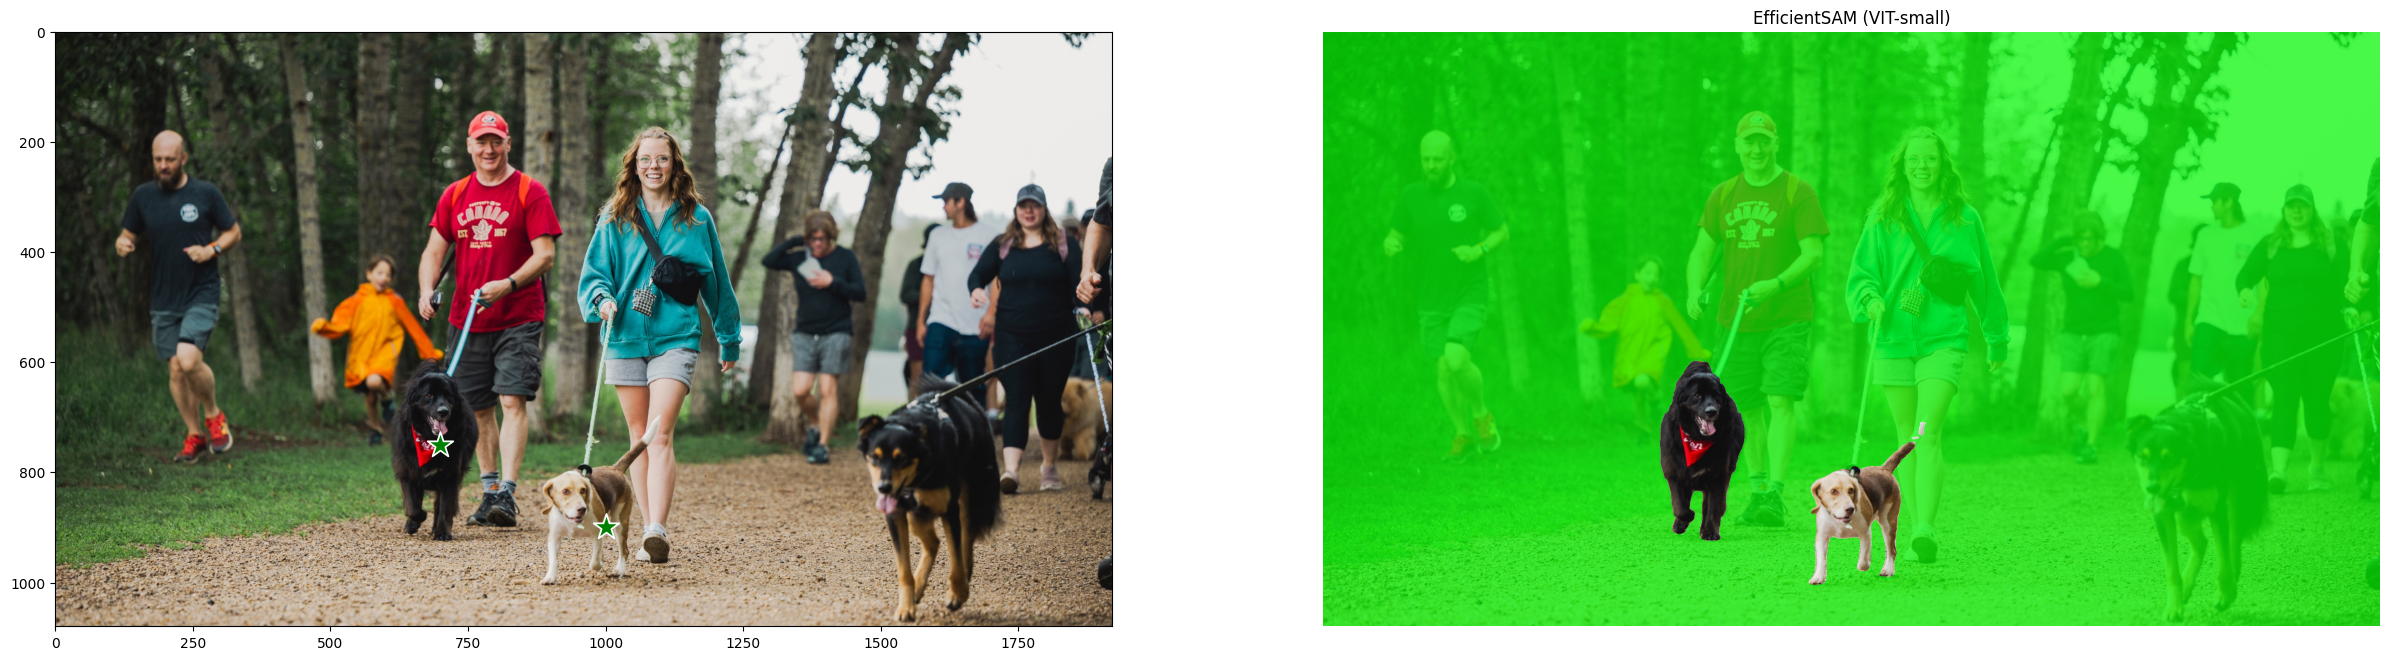

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(30, 30))

input_label = np.array([1, 1])
image_path = "/content/pets-in-the-park-festival.jpg"
input_point = np.array([[700, 750], [1000, 900]])
image = np.array(Image.open(image_path))
show_points(input_point, input_label, ax[0])
ax[0].imshow(image)

ax[1].imshow(image)
mask_efficient_sam_vits = run_ours_box_or_points(image_path, input_point, input_label, efficient_sam_vits_model)
show_anns_ours(mask_efficient_sam_vits, ax[1])
ax[1].title.set_text("EfficientSAM (VIT-small)")
ax[1].axis('off')

plt.show()

## Box Prompt Implementation

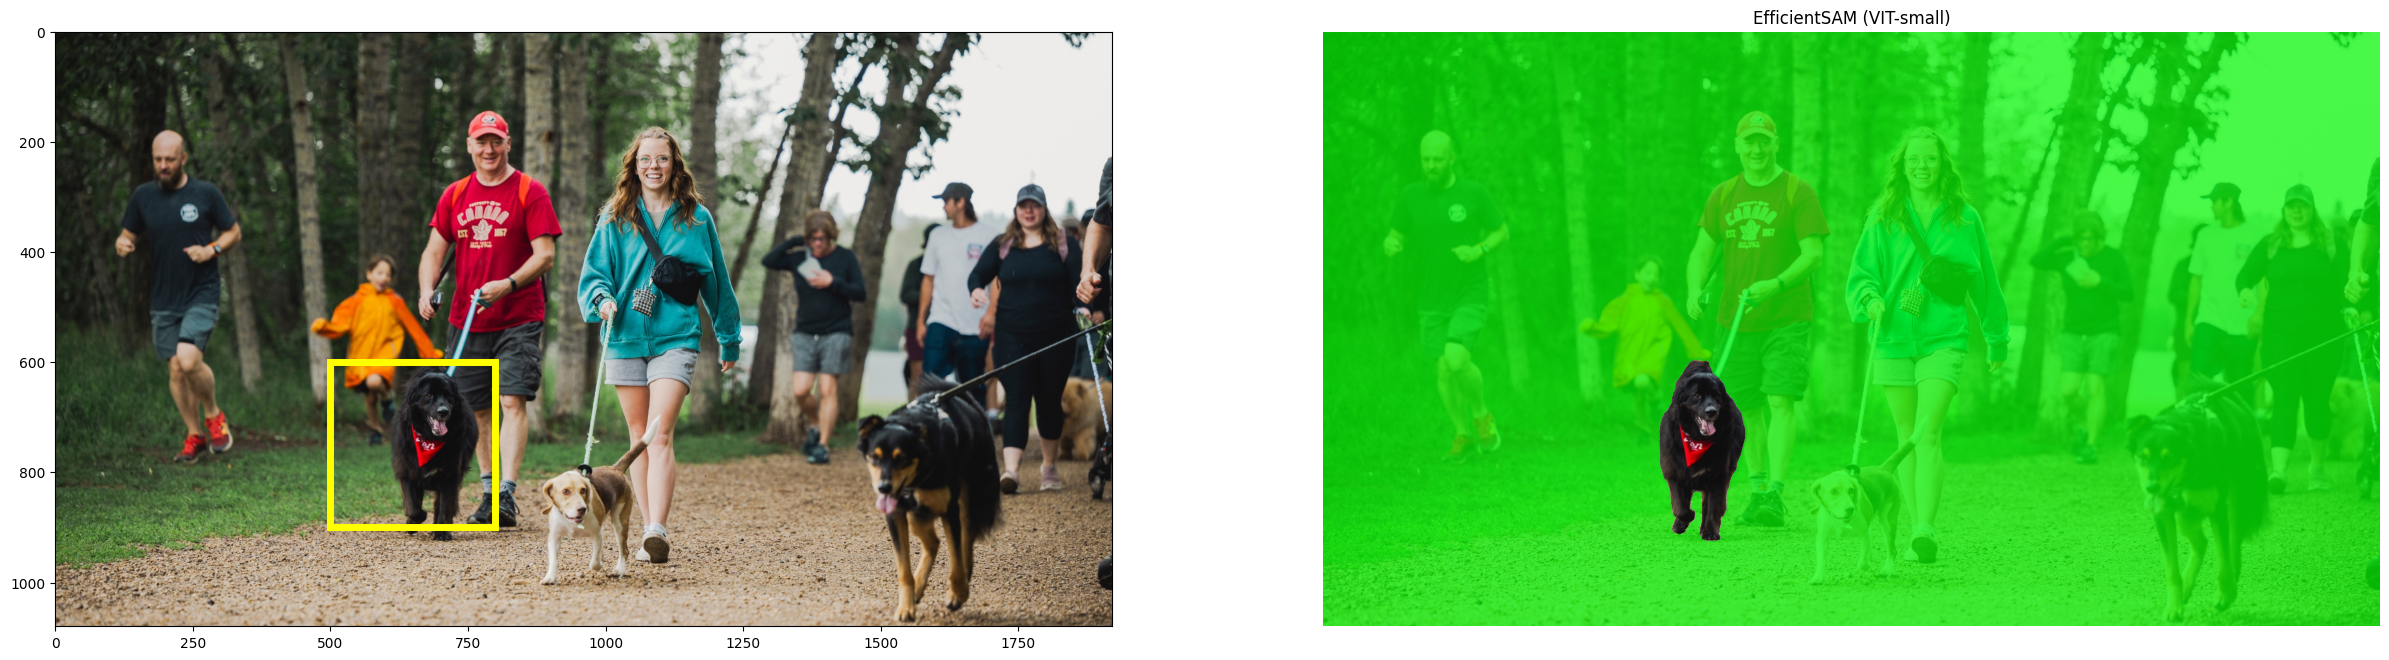

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(30, 30))
input_point = np.array([[500, 600], [800, 900]])
input_label = np.array([2,3])
image_path = "/content/pets-in-the-park-festival.jpg"
image = np.array(Image.open(image_path))
show_points(input_point, input_label, ax[0])
show_box([500,600,800,900], ax[0])
ax[0].imshow(image)

ax[1].imshow(image)
mask_efficient_sam_vits = run_ours_box_or_points(image_path, input_point, input_label, efficient_sam_vits_model)
show_anns_ours(mask_efficient_sam_vits, ax[1])
ax[1].title.set_text("EfficientSAM (VIT-small)")
ax[1].axis('off')

plt.show()

## Segment Everything Implementation

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(30, 30))
image_path = "/content/pets-in-the-park-festival.jpg"
image = np.array(Image.open(image_path))
ax[0].imshow(image)
ax[0].title.set_text("Original")
ax[0].axis('off')

ax[1].imshow(image)
mask_efficient_sam_vits = run_everything_ours(image_path, efficient_sam_vits_model)
show_anns_ours_everything(mask_efficient_sam_vits, ax[1])
ax[1].title.set_text("EfficientSAM")
ax[1].axis('off')


plt.show()